In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import lightgbm as ltb

In [3]:
import pandas as pd
import numpy as np

#df = pd.read_csv(r"C:\Users\kavya\Desktop\Kavya\Intelihub\client\HERC\Latest\data\model_ready_2.csv")

In [4]:
df = pd.read_csv(r"C:\Users\HP\Documents\Load_Forecasting_using_Fbprophet\Final Files fbprophet\Combined_Data_for_model_final_2.csv")

In [5]:
del df['Unnamed: 0']

#### Extracting Cal Features

In [6]:
df['Date'] = pd.to_datetime(df['Date'])

In [7]:
df = df[df['Date']>='2018-01-01']

In [8]:
df['month'] = pd.to_datetime(df['Date']).dt.month
df['weekday'] = pd.to_datetime(df['Date']).dt.weekday
df['hour'] = pd.to_datetime(df['Date']).dt.hour
df['hour_part'] = pd.to_datetime(df['Date']).dt.minute
df['year'] = pd.to_datetime(df['Date']).dt.year
df['day'] = pd.to_datetime(df['Date']).dt.day

# remove outliers in windspeed - checked the max windspeed India recorded - it is around 100
df = df[df['windspeed']<=100]

<AxesSubplot:>

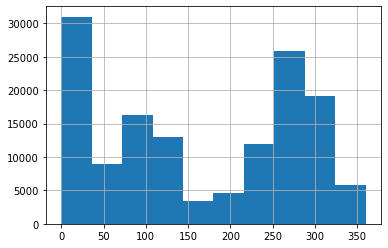

In [9]:
df['winddir'].hist()

In [10]:
def get_season(TimeSeries):
    
    season_list = []
    
    year_list = []
    month_list = []
    for time in TimeSeries:
        year = str(time)[:4]
        month = str(time)[5:7]
        year_list.append(year)
        month_list.append(month) 
       
    for m in month_list:
        if m=='01' or m=='02' or m=='12':
            season_list.append(0)   # Winter
        elif m=='03' or m=='04' or m=='05':
            season_list.append(1) #Spring-Summer
        elif m == '06' or m=='07':
            season_list.append(2) #Paddy/Monsoon
        elif m=='08' or m=='09':
            season_list.append(3) #Late Monsoon
        elif m=='10' or m=='11':
            season_list.append(4) #Autumn
            
    #season = pd.Series(season_list)
    return season_list

In [11]:
season = get_season(df['Date'])

In [12]:
df['Season'] = season

In [13]:
from sklearn import metrics
import numpy as np
from sklearn.model_selection import StratifiedKFold
import itertools
# from skopt import BayesSearchCV as bayes_opt

In [14]:
# check for 0 values and remove
df = df[df['Haryana Load (MW)']>0]

In [15]:
df

,Date,Haryana Load (MW),temp,dew,humidity,windspeed,winddir,cloudcover,visibility,month,weekday,hour,hour_part,year,day,Season
70175,2018-01-01 00:00:00,3880.22,11.0,9.0,87.48,0.0,0.0,0.0,1.0,1,0,0,0,2018,1,0
70176,2018-01-01 00:15:00,3778.15,11.0,9.0,87.48,0.0,0.0,0.0,1.0,1,0,0,15,2018,1,0
70177,2018-01-01 00:30:00,3742.81,11.0,9.0,87.48,0.0,0.0,0.0,1.0,1,0,0,30,2018,1,0
70178,2018-01-01 00:45:00,3627.39,11.0,9.0,87.48,0.0,0.0,0.0,1.0,1,0,0,45,2018,1,0
70179,2018-01-01 01:00:00,3616.50,10.0,8.0,87.38,0.0,0.0,0.0,1.0,1,0,1,0,2018,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210426,2021-12-31 22:45:00,4712.55,10.0,8.0,87.38,0.0,0.0,27.4,2.0,12,4,22,45,2021,31,0
210427,2021-12-31 23:00:00,4649.58,9.2,7.3,88.04,0.0,0.0,28.5,1.3,12,4,23,0,2021,31,0
210428,2021-12-31 23:15:00,4571.39,9.2,7.3,88.04,0.0,0.0,28.5,1.3,12,4,23,15,2021,31,0
210429,2021-12-31 23:30:00,4510.39,9.2,7.3,88.04,0.0,0.0,28.5,1.3,12,4,23,30,2021,31,0


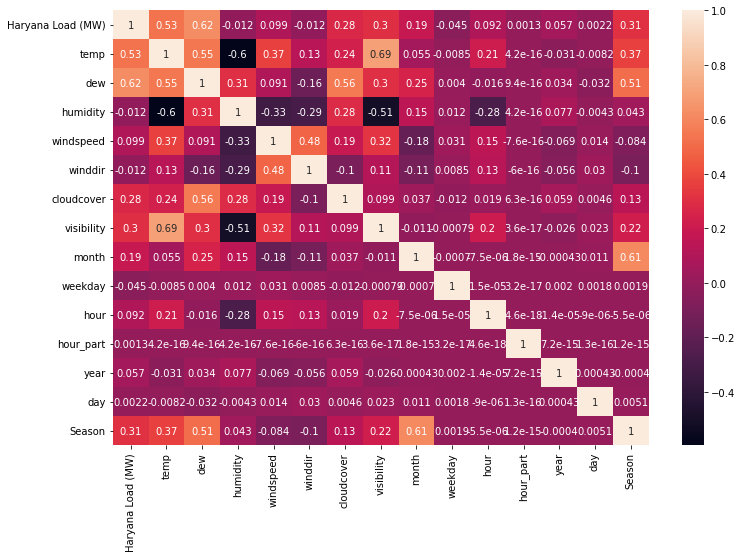

In [16]:
plt.rcParams["figure.figsize"] = (12, 8)
sp = sns.heatmap(df.corr(), annot=True)
plt.show()

#### Based on Analysis, will drop Season, Dew, Cloudcover and Visibility

In [17]:
# Train Data
train = df[df['Date']<="2021-06-01"]

In [18]:
# Test Data
test = df[df['Date']>"2021-06-01"]

In [19]:
train

,Date,Haryana Load (MW),temp,dew,humidity,windspeed,winddir,cloudcover,visibility,month,weekday,hour,hour_part,year,day,Season
70175,2018-01-01 00:00:00,3880.22,11.0,9.0,87.48,0.0,0.0,0.0,1.0,1,0,0,0,2018,1,0
70176,2018-01-01 00:15:00,3778.15,11.0,9.0,87.48,0.0,0.0,0.0,1.0,1,0,0,15,2018,1,0
70177,2018-01-01 00:30:00,3742.81,11.0,9.0,87.48,0.0,0.0,0.0,1.0,1,0,0,30,2018,1,0
70178,2018-01-01 00:45:00,3627.39,11.0,9.0,87.48,0.0,0.0,0.0,1.0,1,0,0,45,2018,1,0
70179,2018-01-01 01:00:00,3616.50,10.0,8.0,87.38,0.0,0.0,0.0,1.0,1,0,1,0,2018,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
189883,2021-05-31 23:00:00,4506.24,31.6,21.5,55.05,10.4,128.0,58.6,2.3,5,0,23,0,2021,31,1
189884,2021-05-31 23:15:00,4176.59,31.6,21.5,55.05,10.4,128.0,58.6,2.3,5,0,23,15,2021,31,1
189885,2021-05-31 23:30:00,3976.80,31.6,21.5,55.05,10.4,128.0,58.6,2.3,5,0,23,30,2021,31,1
189886,2021-05-31 23:45:00,3819.15,31.6,21.5,55.05,10.4,128.0,58.6,2.3,5,0,23,45,2021,31,1


In [20]:
test

,Date,Haryana Load (MW),temp,dew,humidity,windspeed,winddir,cloudcover,visibility,month,weekday,hour,hour_part,year,day,Season
189888,2021-06-01 00:15:00,3639.93,30.0,19.0,51.76,27.7,10.0,50.0,2.0,6,1,0,15,2021,1,2
189889,2021-06-01 00:30:00,3486.01,30.0,19.0,51.76,27.7,10.0,50.0,2.0,6,1,0,30,2021,1,2
189890,2021-06-01 00:45:00,3156.73,30.0,19.0,51.76,27.7,10.0,50.0,2.0,6,1,0,45,2021,1,2
189891,2021-06-01 01:00:00,2776.86,21.0,20.0,94.02,27.7,330.0,100.0,2.0,6,1,1,0,2021,1,2
189892,2021-06-01 01:15:00,2446.95,21.0,20.0,94.02,27.7,330.0,100.0,2.0,6,1,1,15,2021,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210426,2021-12-31 22:45:00,4712.55,10.0,8.0,87.38,0.0,0.0,27.4,2.0,12,4,22,45,2021,31,0
210427,2021-12-31 23:00:00,4649.58,9.2,7.3,88.04,0.0,0.0,28.5,1.3,12,4,23,0,2021,31,0
210428,2021-12-31 23:15:00,4571.39,9.2,7.3,88.04,0.0,0.0,28.5,1.3,12,4,23,15,2021,31,0
210429,2021-12-31 23:30:00,4510.39,9.2,7.3,88.04,0.0,0.0,28.5,1.3,12,4,23,30,2021,31,0


In [21]:
x_train = train[['hour', 'weekday', 'temp',
       'winddir', 'hour_part', 'day', 'month', 'humidity']]
y_train = train[['Haryana Load (MW)']]

In [22]:
x_test = test[['hour', 'weekday', 'temp',
       'winddir', 'hour_part', 'day', 'month', 'humidity']]
y_test = test[['Haryana Load (MW)']]

In [23]:
x_test.describe()

,hour,weekday,temp,winddir,hour_part,day,month,humidity
count,20543.000000,20543.000000,20543.000000,20543.000000,20543.000000,20543.000000,20543.000000,20543.000000
mean,11.500560,2.990751,26.290746,144.249331,22.501095,15.790440,9.004819,72.787525
std,6.922058,1.988310,7.092862,112.560636,16.770591,8.827231,1.998813,19.693465
min,0.000000,0.000000,5.000000,0.000000,0.000000,1.000000,6.000000,19.570000
25%,6.000000,1.000000,21.400000,40.000000,15.000000,8.000000,7.000000,58.110000
50%,12.000000,3.000000,28.000000,120.000000,30.000000,16.000000,9.000000,77.140000
75%,17.500000,5.000000,31.000000,260.000000,37.500000,23.000000,11.000000,88.920000
max,23.000000,6.000000,43.000000,360.000000,45.000000,31.000000,12.000000,100.000000


In [24]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

#### LightGBM

In [53]:
modell = ltb.LGBMRegressor(n_estimators=200, num_leaves=21, max_depth=5)
modell.fit(x_train, y_train)

LGBMRegressor(max_depth=5, n_estimators=200, num_leaves=21)

In [54]:
predsl = modell.predict(x_test)

In [55]:
from sklearn.metrics import r2_score
r2_score(y_test['Haryana Load (MW)'], predsl)

0.7554594639696395

#### R2 Score = 0.755

#### XGB

In [32]:
model = xgb.XGBRegressor()
model.fit(x_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [33]:
preds = model.predict(x_test)

In [34]:
y_test['pred'] = preds

C:\Users\HP\AppData\Local\Temp/ipykernel_4312/2190438978.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test['pred'] = preds


In [35]:
from sklearn.metrics import r2_score
r2_score(y_test['Haryana Load (MW)'],y_test['pred'])

0.7382334186142572

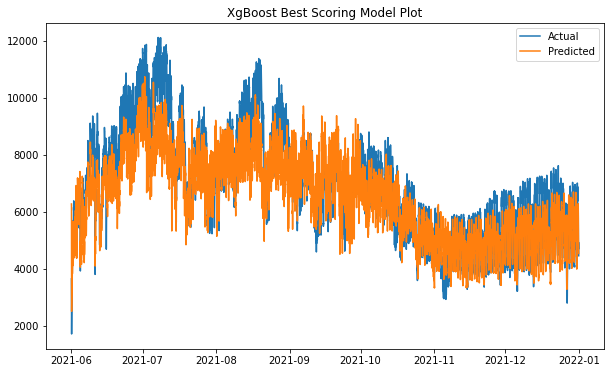

In [36]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams["figure.figsize"] = (10,6)
plt.plot(test['Date'], y_test['Haryana Load (MW)'])
plt.plot(test['Date'], y_test['pred'])
plt.title('XgBoost Best Scoring Model Plot')
plt.legend(['Actual', 'Predicted'])

#### RF

In [37]:
from sklearn.ensemble import RandomForestRegressor

In [38]:
regr = RandomForestRegressor()

In [39]:
regr.fit(x_train, y_train)

C:\Users\HP\AppData\Local\Temp/ipykernel_4312/1990009532.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  regr.fit(x_train, y_train)


RandomForestRegressor()

In [40]:
preds = model.predict(x_test)

In [41]:
y_test['pred'] = preds

C:\Users\HP\AppData\Local\Temp/ipykernel_4312/2190438978.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test['pred'] = preds


In [42]:
from sklearn.metrics import r2_score
r2_score(y_test['Haryana Load (MW)'],y_test['pred'])

0.7382334186142572

#### R2 = 0.7382

#### Inputs for CV Save

In [51]:
# dfX = df[['hour', 'weekday', 'temp',
#        'winddir', 'hour_part', 'day', 'month', 'humidity']]
# dfY = df[['Haryana Load (MW)']]

In [52]:
# dfX.to_csv('X_for_ncv_better.csv')
# dfY.to_csv('Y_for_ncv_better.csv')

#### Bucket Analysis

In [56]:
len(x_train)

119709

In [57]:
train_predictions = modell.predict(x_train)

In [58]:
y_train = y_train.reset_index().drop(columns='index')

In [59]:
y_train_with_error = y_train.join(pd.Series(train_predictions, name='preds'))

In [60]:
y_train_with_error['Error'] = y_train_with_error['Haryana Load (MW)'] - y_train_with_error['preds']

In [61]:
y_train_with_error['Percent Error'] = y_train_with_error['Error']*100/y_train_with_error['Haryana Load (MW)']

In [62]:
y_errorful_buckets = y_train_with_error[np.abs(y_train_with_error['Percent Error']) > 8]

In [63]:
x_train = x_train.reset_index().drop(columns='index')

In [64]:
y_errorful_buckets.index

Int64Index([    16,     20,     31,     32,     33,     34,     37,     38,
                39,     40,
            ...
            119699, 119700, 119701, 119702, 119703, 119704, 119705, 119706,
            119707, 119708],
           dtype='int64', length=45520)

In [65]:
x_train_new = x_train.drop(index = y_errorful_buckets.index)

In [66]:
x_train_new

,hour,weekday,temp,winddir,hour_part,day,month,humidity
0,0,0,11.0,0.0,0,1,1,87.48
1,0,0,11.0,0.0,15,1,1,87.48
2,0,0,11.0,0.0,30,1,1,87.48
3,0,0,11.0,0.0,45,1,1,87.48
4,1,0,10.0,0.0,0,1,1,87.38
...,...,...,...,...,...,...,...,...
119693,20,0,33.5,110.0,15,31,5,49.88
119694,20,0,33.5,110.0,30,31,5,49.88
119695,20,0,33.5,110.0,45,31,5,49.88
119696,21,0,34.0,120.0,0,31,5,41.27


In [67]:
y_train_new = y_train.drop(index = y_errorful_buckets.index)

In [68]:
len(y_train_new)

74189

In [69]:
modell2 = ltb.LGBMRegressor(n_estimators=200, num_leaves=21, max_depth=5)

In [70]:
modell2.fit(x_train_new, y_train_new)

LGBMRegressor(max_depth=5, n_estimators=200, num_leaves=21)

In [71]:
x_test

,hour,weekday,temp,winddir,hour_part,day,month,humidity
189888,0,1,30.0,10.0,15,1,6,51.76
189889,0,1,30.0,10.0,30,1,6,51.76
189890,0,1,30.0,10.0,45,1,6,51.76
189891,1,1,21.0,330.0,0,1,6,94.02
189892,1,1,21.0,330.0,15,1,6,94.02
...,...,...,...,...,...,...,...,...
210426,22,4,10.0,0.0,45,31,12,87.38
210427,23,4,9.2,0.0,0,31,12,88.04
210428,23,4,9.2,0.0,15,31,12,88.04
210429,23,4,9.2,0.0,30,31,12,88.04


In [72]:
preds2 = modell2.predict(x_test)

In [73]:
preds2

array([7552.53617743, 7536.65496827, 7536.65496827, ..., 4848.88377344,
       4774.25700279, 4774.25700279])

In [74]:
from sklearn.metrics import r2_score
r2_score(y_test['Haryana Load (MW)'], preds2)

0.758158727874644

#### R2 = 0.758, when error threshold = 8%

In [47]:
from sklearn.metrics import mean_squared_error

rmse = np.sqrt(mean_squared_error(y_test['Haryana Load (MW)'], preds2))

# mx = y_test['Haryana Load (MW)'].max()
# mn = y_test['Haryana Load (MW)'].min()
# nrmse = rmse/(mx - mn)

In [48]:
y_test

,Haryana Load (MW)
189888,3639.93
189889,3486.01
189890,3156.73
189891,2776.86
189892,2446.95
...,...
210426,4712.55
210427,4649.58
210428,4571.39
210429,4510.39


In [49]:
print(rmse)

1001.7714450625689


In [50]:
def MAPE(Y_actual,Y_Predicted):
    mape = np.mean(np.abs((Y_actual - Y_Predicted)/Y_actual))*100
    return mape

In [51]:
MAPE(y_test['Haryana Load (MW)'], preds2)

11.13874997141369

In [52]:
len(preds2)

20543

#### Analyze Errorful buckets

In [75]:
y_errorful_buckets

,Haryana Load (MW),preds,Error,Percent Error
16,3736.08,4092.117337,-356.037337,-9.529703
20,4265.82,4738.266979,-472.446979,-11.075174
31,4799.47,5299.888471,-500.418471,-10.426536
32,4587.46,5290.553216,-703.093216,-15.326416
33,4567.14,5292.246630,-725.106630,-15.876602
...,...,...,...,...
119704,4506.24,6828.659733,-2322.419733,-51.537862
119705,4176.59,6821.016389,-2644.426389,-63.315441
119706,3976.80,6821.016389,-2844.216389,-71.520227
119707,3819.15,6821.016389,-3001.866389,-78.600379


#### Plots

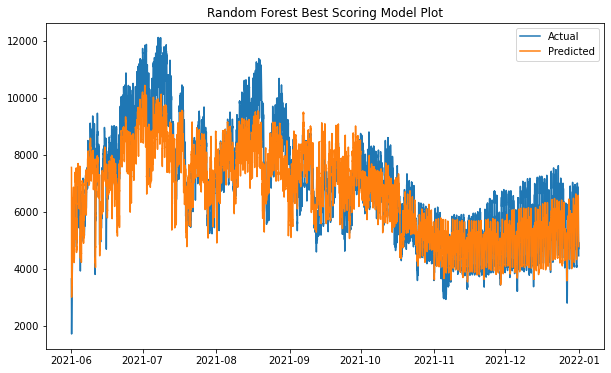

In [76]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams["figure.figsize"] = (10,6)
plt.plot(test['Date'], y_test['Haryana Load (MW)'])
plt.plot(test['Date'], preds2)
plt.title('Random Forest Best Scoring Model Plot')
plt.legend(['Actual', 'Predicted'])